In [1]:
# imports
import math
import itertools as it
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

# Initialize

In [2]:
# set up demo graph
n = 6
G_A = nx.Graph()
Ef_A = nx.Graph()
P_A = nx.complete_graph(range(1,n+1))
#
G_A.add_nodes_from(range(1,n+1))
G_A.add_edges_from(((4,5),(3,2),(4,3),(5,2),(6,4),(1,5),(1,2)))
e1 = (5,4)
e2 = (4,5)
f1 = e1 in P_A.edges()
f2 = e2 in P_A.edges()

print(f1)
print(f2)
#P_A.remove_edge(*e)
#f1 = e in P_A.edges()
#print(f1)

#display



True
True


# Algorithm 1: DegreeDiffElim

In [3]:
def DegreeDiffElim(G_A,P_A,kA):
    edges = list(P_A.edges())
    for e in edges:
        if abs(G_A.degree(e[0]) - G_A.degree(e[1])) > kA:
            P_A.remove_edge(*e)
    return P_A

# Algorithm 2: FixedDegElim

In [4]:
def FixedDegElim(G_A,P_A,Ef_A):
    edges = list(P_A.edges())
    for e in edges:
        if Ef_A.degree(e[0]) > G_A.degree(e[1]):
            P_A.remove_edge(*e)
    return P_A

# Algorithm 3: Helper Functions

In [5]:
# larger neighborhood should be Ni (line 6 in DKAS)
def sortByLength(set1,set2):
    if len(set1) == len(set2):
        return set1, set2
    elif len(set1) > len(set2):
        return set1, set2
    else:
        return set2,set1

In [6]:
# mostly as written in DASG paper
# page 8, lines 10-20
def assign_weight_k1(i,j,G_A,P_A):
    e = (i,j)
    if e in P_A.edges():
        if G_A.degree(i) > G_A.degree(j):
            return -2*(G_A.degree(i) - G_A.degree(j))
        elif G_A.degree(j) > G_A.degree(j):
            return -2*(G_A.degree(j) - G_A.degree(i))
        else:
            return -abs(G_A.degree(i) - G_A.degree(j))
    else:
        return -math.inf

In [7]:
# this is for d2v and v2d
def assign_weight_k2(neighbor,dummy_parent,Ef_A):
    edge = (neighbor,dummy_parent)
    if edge in Ef_A.edges():
        return -math.inf
    else: return -2

In [8]:
# returns python set of integers, sorted by length
def pair2neighborhood(g,i,j):
    N_i = set((e for e in nx.neighbors(g,i)))
    N_j = set((f for f in nx.neighbors(g,j)))
    print("1: neighbors")
    print(N_i)
    print(N_j)
    try:
        N_i.remove(j)
        N_j.remove(i)
    except(ValueError,TypeError,KeyError):
        print("")
    Ni,Nj = sortByLength(N_i,N_j)
    print(f"2: remove {i} or {j}")
    print(Ni)
    print(Nj)
    #remove duplicates
    #duplicates = Ni.intersection(Nj)
    #for d in duplicates:
    #    Ni.remove(d)
    #    Nj.remove(d)
    #print(f"3: remove duplicates: {duplicates}")
    #print(Ni)
    #print(Nj)
    return Ni,Nj

### Algorithm 3: Build Cost Matrix

In [9]:
# build-cost-matrix using python set
def BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A):
    _Ni_int,_Nj_int = pair2neighborhood(G_A,i,j)
# initialize    
    CostMatrix = nx.Graph()
    Ni = []
    Nj = []
    xi = []
    xj = []
    
# make vertices
    for e in _Ni_int:
        name = "i" + str(e)
        Ni.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=False,parent=i,value=e)
    for f in _Nj_int:
        name = "j" + str(f)
        Nj.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=False,parent=j,value=f)
        
    print(f"vertices for Ni: {Ni}")
    print(f"vertices for Nj: {Nj}")

# # lines 8-9
    degDiff = abs(G_A.degree(i) - G_A.degree(j))
# # larger set xi goes in right partition of graph
    for xe in range(1,degDiff+k_A+1):
        name = "xi" + str(xe)
        xi.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=True,parent=i,value=-1)
    for xf in range(1,k_A+1):
        name = "xj" + str(xf)
        xj.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=True,parent=j,value=-1)
        
    print(f"xi: {xi}")
    print(f"xj: {xj}")
    
# make edges (weights negated)
    value = nx.get_node_attributes(CostMatrix,'value')
    parent = nx.get_node_attributes(CostMatrix,'parent')
# # vertex to vertex
    V2V = []
    for e0 in it.product(Ni,Nj):
        weight = assign_weight_k1(value[e0[0]],value[e0[1]],G_A,P_A)
        print(f" vertex to vertex (Ni cross Nj): {e0} ;weight: {weight}")
        V2V.append((*e0,weight))
        
# # vertex to dummy
    D2V = []
# # #"draw an edge between vj and xj"
    for e1 in it.product(xj,Nj):
        weight = assign_weight_k2(value[e1[1]],parent[e1[0]],Ef_A)
        print(f" dummy to vertex (xj cross Nj): {e1} ;weight: {weight}")
        D2V.append((*e1,weight))
    
    V2D = []
# # #"draw an edge between ui and xi"
    for e2 in it.product(Ni,xi):
        weight = assign_weight_k2(value[e2[0]],parent[e2[1]],Ef_A)
        print(f" vertex to dummy (Ni cross xi): {e2} ;weight: {weight}")
        D2V.append((*e2,weight))

# # dummy to dummy
    D2D = []
    for e3 in it.product(xj,xi):
        print(f"dummy to dummy {e3}")
        D2D.append((*e3,0))

# add weighted edges
    CostMatrix.add_weighted_edges_from(V2V)
    CostMatrix.add_weighted_edges_from(D2V)
    CostMatrix.add_weighted_edges_from(V2D)
    CostMatrix.add_weighted_edges_from(D2D)
# display
    l,r = bipartite.sets(CostMatrix)
    print(f"bipartite.sets left set {l}")
    print(f"bipartite.sets right set {r}")
    return CostMatrix 

# HungarianSolve: find cost perfect matching

In [10]:
# hungarian solve from page 9 of detect almost symmetries
# calculates the sum of the weights in the matching
def HungarianSolve(CostMatrix):
    Matching = nx.max_weight_matching(CostMatrix,maxcardinality=True)
    print("is perfect matching: ",nx.is_perfect_matching(CostMatrix,Matching))
    cost = 0
    deleteEdges = []
    # cost multiplied by negative -1
    dummy = nx.get_node_attributes(CostMatrix,"dummy")
    for m in Matching:
        i = m[0]
        j = m[1]
        #
        #
        # 'ui is dummy T/F?' XOR 'j is dummy T/F?'
        #
        # "From the solution we determine when an edge {ui, xi} or {vj, xj}
        # is in the optimal assignment. The former corresponds to the deletion of edge {i, u} in
        # GA, the later to the deletion of edge {j, v}."
        #
        if dummy[i] ^ dummy[j]:
            print("del edge")
            deleteEdges.append(m)
            cost +=-1*CostMatrix[i][j]['weight']
        print(f"weight: {CostMatrix[i][j]}, edge: {i},{j}")
        # 
    return cost,deleteEdges

# Refine By Matching

In [12]:
#

# Driver

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


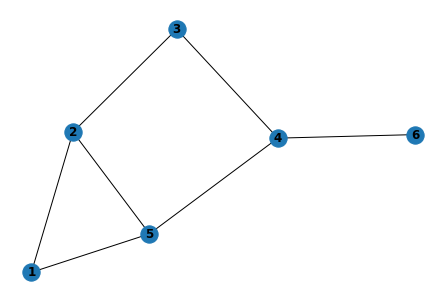

0: i,j = 2,5
1: neighbors
{1, 3, 5}
{1, 2, 4}
2: remove 2 or 5
{1, 3}
{1, 4}
vertices for Ni: ['i1', 'i3']
vertices for Nj: ['j1', 'j4']
xi: ['xi1']
xj: ['xj1']
 vertex to vertex (Ni cross Nj): ('i1', 'j1') ;weight: -inf
 vertex to vertex (Ni cross Nj): ('i1', 'j4') ;weight: -1
 vertex to vertex (Ni cross Nj): ('i3', 'j1') ;weight: 0
 vertex to vertex (Ni cross Nj): ('i3', 'j4') ;weight: -1
 dummy to vertex (xj cross Nj): ('xj1', 'j1') ;weight: -2
 dummy to vertex (xj cross Nj): ('xj1', 'j4') ;weight: -2
 vertex to dummy (Ni cross xi): ('i1', 'xi1') ;weight: -2
 vertex to dummy (Ni cross xi): ('i3', 'xi1') ;weight: -2
dummy to dummy ('xj1', 'xi1')
bipartite.sets left set {'i1', 'i3', 'xj1'}
bipartite.sets right set {'j1', 'j4', 'xi1'}
!! HungarianSolve output
is perfect matching:  True
weight: {'weight': -1}, edge: i1,j4
weight: {'weight': 0}, edge: j1,i3
weight: {'weight': 0}, edge: xj1,xi1
cost:  0
Matching:  []
!! HungarianSolve output above


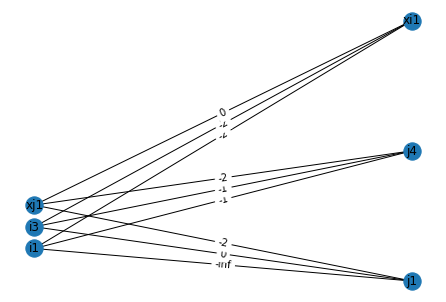

In [11]:
nx.draw(G_A, with_labels=True, font_weight='bold')
plt.show()
#initialize
k_A = 1
i = 2
j = 5
print(f"0: i,j = {i},{j}")
cost_fixed = abs(G_A.degree(i) - G_A.degree(j))
p_a = DegreeDiffElim(G_A,P_A,k_A)
cm = BuildCostMatrix(i,j,G_A,p_a,Ef_A,k_A)
# compute matching
print("!! HungarianSolve output")
cost, deleteEdges = HungarianSolve(cm)
print("cost: ",cost)
print("Matching: ",deleteEdges)
print("!! HungarianSolve output above")
l, r = bipartite.sets(cm)
pos = dict()
pos.update( (nn, (1, ii+ len(l)/2)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
pos.update( (nn, (2, n*ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
nx.draw(cm, pos=pos,with_labels=True)

#edge weights
labels = nx.get_edge_attributes(cm, "weight")
nx.draw_networkx_edge_labels(cm, pos=pos, edge_labels=labels)
plt.show()